In [1]:
# ~~~~~~~~~~~~~~ Libraries
import sys, os
import mne # Python package for processing and analyzing electrophysiological data
import numpy as np
from glob import glob # look for all the pathnames matching a specified pattern according to the rules
import matplotlib.pyplot as plt
from mne.preprocessing import ICA # ICA (Independent Component Analysis) algorithm, which is for artifact removal
from autoreject import AutoReject # Python package for automatically rejecting bad epochs in EEG/MEG data
import json
import re
import pandas as pd
# ~~~~~~~~~~~~~~ Libraries ~~~~~~~~~~~~~~

# ~~~~~~~~~~~~~~ open json paramete files and import functions
# open parent folder of this script
os.chdir('/u/kazma/MINT/code/')

with open("config.json") as f: # import variables from config.json
    config = json.load(f) 
globals().update(config)
sys.path.append(BASE_DIR) # import custom python packages
print(os.getcwd())
from utils import create_if_not_exist, download_datashare_dir, update_eeg_headers, make_31_montage, calculate_artificial_channels
# ~~~~~~~~~~~~~~ open json paramete files and import functions ~~~~~~~~~~~~~~


/viper/u/kazma/MINT/code


In [2]:
# ~~~~~~~~~~~~~~ Pre-processing Parameters
group = 'adult'
sub_name = 'sub-01'
modality = 'visual'
session = 1
print(f"\n\n Processing {modality} EEG session {session} of {group} for RDM: {sub_name}\n\n")
# ~~~~~~~~~~~~~~ Pre-processing Parameters ~~~~~~~~~~~~~~



# ~~~~~~~~~~~~~~ Path settings and make folders
group_name = f"raw-{group}"
datashare_dir_path = os.path.join('MINT', group_name, sub_name, modality) #  "DATASHARE_RAW_FOLDER": "MINT/raw/",
# create directories
raw_target_dir_path = os.path.join(BASE_DIR, 'data', group,'raw', modality, sub_name) # BASE_DIR: "/u/kazma/MINT/"
interim_target_dir_path = os.path.join(BASE_DIR, 'data', group, 'interim', modality, sub_name)
processed_target_dir_path = os.path.join(BASE_DIR, 'data', group, 'processed', modality, sub_name)
create_if_not_exist(raw_target_dir_path) 
create_if_not_exist(interim_target_dir_path)
create_if_not_exist(processed_target_dir_path) 
# the interested file name
target_file_name = f"{raw_target_dir_path}/{sub_name}_ses-0{session}_{modality}.vhdr"
# ~~~~~~~~~~~~~~ Path settings and make folders ~~~~~~~~~~~~~~





 Processing visual EEG session 1 of adult for RDM: sub-01




In [8]:
# ~~~~~~~~~~~~~~ Load data and the data ajustments
raw = mne.io.read_raw_brainvision(target_file_name,  # Brain vision file format contains three files .vhdr for the header, .eeg for the data, and .vmrk for events
                                  misc='auto', # misc = Specifies that channels labeled as miscellaneous (e.g., auxiliary or non-EEG channels) should be automatically detected.
                                  scale=1.0, # 1.0 means no change for scale
                                  preload=True, # the data is loaded directly into memory. This allows for faster processing 
                                  verbose=False) # Suppresses output during the loading process (helpful when you don’t want too much logging information
raw.rename_channels({'VP': 'Fp2',  # In this case, the channel labeled VP is renamed to Fp2, and VM is renamed to Fp1.
                     'VM': 'Fp1'})
raw.set_montage(make_31_montage(raw))


# Load csv file
csv_file = [f for f in os.listdir(raw_target_dir_path) if f.endswith('.csv')] # List all files in the folder and filter for .csv files
csv_df = pd.read_csv(os.path.join(raw_target_dir_path, csv_file[0])) # Load the CSV file into a DataFrame """



/tmp/ipykernel_3142220/3613621298.py:2: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(target_file_name,  # Brain vision file format contains three files .vhdr for the header, .eeg for the data, and .vmrk for events


In [9]:

# Define conditions
conditions = [
    csv_df['image_name'].str.contains('totaldot'),       # Condition 1: contains 'totaledot'
    csv_df['image_name'].str.contains('circum')    # Condition 2: contains 'circumference'
]

# Define corresponding values to increase the 'index' by
values = [
    csv_df['image_number'] + 70,   # Increase by 70 if 'totaledot' is found
    csv_df['image_number'] + 140   # Increase by 140 if 'circumference' is found
]

# Apply np.select() to update the 'index' based on conditions
csv_df['image_number'] = np.select(conditions, values, default=csv_df['image_number'])

# Define conditions
conditions = [
    csv_df['image_name'].str.startswith('2'),       # Condition 1: contains 'singledot'
    csv_df['image_name'].str.startswith('3'), 
    csv_df['image_name'].str.startswith('4'),
    csv_df['image_name'].str.startswith('5'),
    csv_df['image_name'].str.startswith('6')       # Condition 2: contains 'circumference'
]

# Define corresponding values to increase the 'index' by
values = [
    csv_df['image_number'] + 210,   # Increase by 70 if 'singledot' is found
    csv_df['image_number'] + 210*2,
    csv_df['image_number'] + 210*3,
    csv_df['image_number'] + 210*4,
    csv_df['image_number'] + 210*5   # Increase by 140 if 'circumference' is found
]

csv_df['image_number'] = np.select(conditions, values, default=csv_df['image_number'])
print(csv_df[csv_df['image_number']==1260]['image_name'])


623    6_con_circum_image_70.png
Name: image_name, dtype: object


In [10]:
EVENT = np.array(csv_df['image_name'])
EVENT_ID = dict(zip(csv_df['image_name'], csv_df['image_number']))

# delete remaining stimulus events / This part of the code removes specific types of events from the annotations in the EEG data
indices_to_remove = [i for i, j in enumerate(raw.annotations.description) if  "Segment" in j or "actiCAP" in j or re.match(r'Stimulus/S (5[1-9]|6[0-7])', j)]
raw.annotations.delete(indices_to_remove)
raw.annotations.description = EVENT
# interested duration of each trial (e.g., 800ms after the onset of image)
raw.annotations.duration = np.array([POSTSTIM_WINDOW for _ in raw.annotations.description])

# get events (number of events, 3), each row represents [event time, previous_event, event_id]
events, event_id = mne.events_from_annotations(raw, event_id=EVENT_ID)

# resample
raw, events = raw.resample(SFREQ, events = events) # raw.resample(SFREQ, events=events): Resamples the raw EEG data to a new sampling frequency (SFREQ) while adjusting the timing of the events accordingly.
raw.events = events #  This assigns the resampled events back to the raw object, so the events remain associated with the data after resampling.
# ~~~~~~~~~~~~~~ Load data and the data ajustments ~~~~~~~~~~~~~~

Used Annotations descriptions: ['1_con_circum_image_1.png', '1_con_circum_image_10.png', '1_con_circum_image_11.png', '1_con_circum_image_12.png', '1_con_circum_image_13.png', '1_con_circum_image_14.png', '1_con_circum_image_15.png', '1_con_circum_image_16.png', '1_con_circum_image_17.png', '1_con_circum_image_18.png', '1_con_circum_image_19.png', '1_con_circum_image_2.png', '1_con_circum_image_20.png', '1_con_circum_image_21.png', '1_con_circum_image_22.png', '1_con_circum_image_23.png', '1_con_circum_image_24.png', '1_con_circum_image_25.png', '1_con_circum_image_26.png', '1_con_circum_image_27.png', '1_con_circum_image_28.png', '1_con_circum_image_29.png', '1_con_circum_image_3.png', '1_con_circum_image_30.png', '1_con_circum_image_31.png', '1_con_circum_image_32.png', '1_con_circum_image_33.png', '1_con_circum_image_34.png', '1_con_circum_image_35.png', '1_con_circum_image_36.png', '1_con_circum_image_37.png', '1_con_circum_image_38.png', '1_con_circum_image_39.png', '1_con_circum_

In [11]:

# creates new artificial channels representing eye movements, using specific EEG channel pairs.
raw = calculate_artificial_channels(raw.copy(), pairs=[['Fp1', 'Fp2'],['F9', 'F10']], labels=['eyeV', 'eyeH']) # ['Fp1', 'Fp2']: These are the frontal electrodes typically used to capture vertical eye movements (denoted as eyeV in this case). ['F9', 'F10']: These electrodes are often placed near the eyes and can be used to capture horizontal eye movements (denoted as eyeH).
# raw.drop_channels(['Fp1']) # former eye channel (dummy name)

# save
raw.save(f"{interim_target_dir_path}/RDM_raw.fif", overwrite=True) # .fif file, which is a standard file format used in MNE for storing EEG/MEG data.


Creating RawArray with float64 data, n_channels=1, n_times=471560
    Range : 0 ... 471559 =      0.000 ...   943.118 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=471560
    Range : 0 ... 471559 =      0.000 ...   943.118 secs
Ready.
Writing /u/kazma/MINT/data/adult/interim/visual/sub-01/RDM_raw.fif
Closing /u/kazma/MINT/data/adult/interim/visual/sub-01/RDM_raw.fif
[done]


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 16501 samples (33.002 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  32 | elapsed:   29.3s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  15 out of  32 | elapsed:   30.0s remaining:   34.0s
[Parallel(n_jobs=-1)]: Done  22 out of  32 | elapsed:   30.4s remaining:   13.8s


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:   30.7s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  32 | elapsed:    6.3s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done  15 out of  32 | elapsed:    7.0s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  22 out of  32 | elapsed:    7.5s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:    7.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    7.6s finished


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 61.9s.
Using EOG channels: eyeV, eyeH
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.5

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Found 3 independent components correlating with EOG signal.


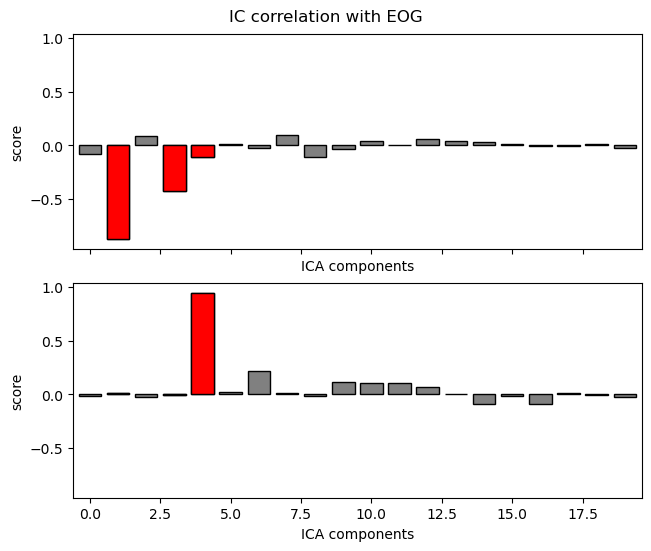

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
471 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
471 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
471 matching events found
No baseline correction applied
0 projection items activated
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


<RawBrainVision | sub-01_ses-01_visual.eeg, 31 x 471560 (943.1 s), ~111.6 MB, data loaded>

In [12]:
# ~~~~~~~~~~~~~~ band-pass filter
raw.filter(l_freq=PREPROC_PARAMS["hpf"], # high-pass
           h_freq=PREPROC_PARAMS["lpf"], # low-pass
           method='fir', #  Finite Impulse Response (FIR) filter 
           fir_design='firwin', # a popular window method for designing FIR filters
           skip_by_annotation='EDGE boundary', # This skips data points marked by annotations such as "EDGE" or "boundary"
           n_jobs=-1) # This allows the filtering to be done in parallel, using all available CPU cores
# ~~~~~~~~~~~~~~ band-pass filter  ~~~~~~~~~~~~~~


# ~~~~~~~~~~~~~~ eye movement correction
if PREPROC_PARAMS["emc"] == "True":
    filt_raw = raw.copy().filter(l_freq=1.0, h_freq=None, n_jobs=-1)
    
    # ICA model to the filtered EEG data
    ica = ICA(n_components=20, # set the number of ICA to estimate
              max_iter="auto", # Automatically determines the maximum number of iterations for ICA convergence.
              method='picard', # This specifies the ICA algorithm to use. Picard is an efficient ICA algorithm suitable for EEG data.
              random_state=97) # Sets a random seed for reproducibility.
    ica.fit(filt_raw) # bads seem to be ignored by default

    # automatic detection of EOG/EMG components
    ica.exclude = []
    # find which ICs match the EOG pattern
    indices, scores = ica.find_bads_eog(raw)
    print(f'Found {len(indices)} independent components correlating with EOG signal.')
    ica.exclude.extend(indices) # Adds the EOG-correlated ICs to the exclude list. These components will later be removed from the data.

    # barplot of ICA component "EOG/EMG match" scores
    f = ica.plot_scores(scores,
                    title=f'IC correlation with EOG',
                    show=True)
    f.savefig(f"{interim_target_dir_path}/ica_scores_RDM.png", dpi=100)

    # plot diagnostics
    if indices: # only if some components were found to correlate with EOG/EMG
        g = ica.plot_properties(raw, 
                                picks=indices, 
                                show=False)
        for gi, p in zip(g, indices):
            gi.savefig(f"{interim_target_dir_path}/ica_diagnostics_ic{p}_RDM.png", dpi=100)
    plt.close('all')

    # This applies the ICA solution to the raw EEG data,
    ica.apply(raw)
# ~~~~~~~~~~~~~~ eye movement correction ~~~~~~~~~~~~~~

# ~~~~~~~~~~~~~~ remove eye-movement related channels
channels_to_remove = ['Fp1', 'eyeV', 'eyeH']  
raw.drop_channels(channels_to_remove) # former eye channel (dummy name)
# ~~~~~~~~~~~~~~ remove eye-movement related channels ~~~~~~~~~~~~~~


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1260 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1260 events and 551 original time points ...
0 bad epochs dropped


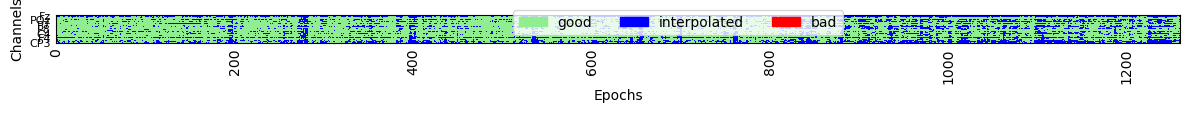

epochs are saved


In [ ]:
# ~~~~~~~~~~~~~~ reference 
raw.set_eeg_reference(PREPROC_PARAMS["ref"], projection=False) #  average of all electrodes is used as the reference. This indicates that the reference should be applied directly
# ~~~~~~~~~~~~~~ reference ~~~~~~~~~~~~~~


# ~~~~~~~~~~~~~~ epoching
epochs = mne.Epochs(raw, # The continuous EEG data
                    events, # This is an array of events detected in the EEG data
                    event_id=EVENT_ID, #event_id,
                    tmin=PREPROC_PARAMS["base"][0], # the start time = -100ms
                    tmax=PREPROC_PARAMS["tmax"], # The end time of each epoch = 1s
                    baseline=tuple(PREPROC_PARAMS["base"]), # (-100 - 0), Baseline correction subtracts the mean signal in this window from the rest of the epoch to remove slow drifts or offset in the data.
                    detrend=PREPROC_PARAMS["det"], # it removes any linear trends (slow drifts) in the data.
                    proj=False,
                    reject_by_annotation=False, 
                    preload=True)
# ~~~~~~~~~~~~~~ epoching ~~~~~~~~~~~~~~


# ~~~~~~~~~~~~~~  autoreject
if PREPROC_PARAMS["ar"] != "False":
    
    if PREPROC_PARAMS["ar"] == "interpolate":        
        n_interpolate=[len(epochs.info['ch_names'])] # This means the maximum number of channels (equal to the number of channels in the data) will be interpolated, which effectively interpolates all bad channels.
        consensus=[len(epochs.info['ch_names'])]  # Similarly, the consensus parameter is set to match the number of channels
    elif PREPROC_PARAMS["ar"] == "interpolate_reject":    
        n_interpolate = [4, 8, 12, 16]
        consensus = np.linspace(0, 1.0, 11)
    else:
        print("ERROR: No valid AR method provided in config.json, exiting!")
        sys.exit(1)
    
    # automated estimation of rejection threshold based on channel and trial per participant
    ar = AutoReject(n_interpolate=n_interpolate, # The number of channels to interpolate if they are detected as noisy.
                    consensus=consensus, # The proportion of channels that must agree to mark a trial as noisy.
                    random_state=11, # Ensures the results are reproducible by setting the random seed
                    n_jobs=-1, 
                    verbose=False) # Suppresses the printing of verbose output.
    ar.fit(epochs)  # The autoreject algorithm is fitted to the epochs, analyzing the data to determine which trials or channels are noisy.
    epochs, reject_log = ar.transform(epochs.copy(), return_log=True) # epochs = The cleaned EEG epochs after autoreject has been applied. reject_log = A log of which trials were rejected or which channels were interpolated.

    # plot the rejection log and save plot
    rej_plot = reject_log.plot('horizontal', show=True)
    rej_plot.savefig(f"{interim_target_dir_path}/autoreject_RDM.png", dpi=100)
    reject_log.save(f"{interim_target_dir_path}/autoreject_RDM.npz", overwrite=True) # must end with .npz, compressed numpy file format
# ~~~~~~~~~~~~~~  autoreject  ~~~~~~~~~~~~~~ 


# ~~~~~~~~~~~~~~ delete surplus trials: SKIP


# ~~~~~~~~~~~~~~ save epochs
epochs.save(f"{interim_target_dir_path}/RDM_epochs-epo.fif", overwrite=True)
print("epochs are saved")
# ~~~~~~~~~~~~~~save epochs ~~~~~~~~~~~~~~
